# The Option-Critic Architecture

Simple implementation of the [Option-Critic Architecture](https://arxiv.org/abs/1609.05140) on the Four-rooms environment.

### 1 Import Libraries and Modules

In [2]:
from fourrooms import FourRooms
from utils import *
import copy

In [3]:
from time import sleep

In [4]:
import numpy as np

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gym

### 2 Test Environment

Taking a look at how the environment looks like.

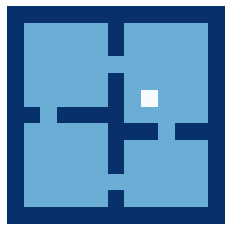

In [5]:
env = FourRooms()
env.reset()

clear_output(True)
plt.imshow(env.render(show_goal=False), cmap='Blues')
plt.axis('off')
plt.show()

Runing a few random iterations to observe how the agents behavior.

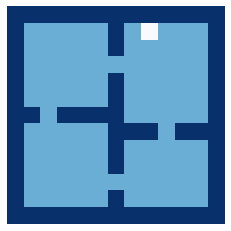

In [6]:
nsteps = 100
nactions = env.action_space.shape[0]

for step in range(nsteps):
    
    action = np.random.randint(nactions)
    
    state, reward, done, _ = env.step(action)
    
    clear_output(True)
    plt.imshow(env.render(show_goal=False), cmap='Blues')
    plt.axis('off')
    plt.show()

### 3 Train using Option-Critic

Setting the hyperparameters.

In [7]:
# Discount
discount = 0.99

# Learning rates - termination, intra-option, critic
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5

# Epsilon for epsilon-greedy for policy over options
epsilon = 1e-1

# Temperature for softmax
temperature = 1e-2

# Number of runs
nruns = 1

# Number of episodes per run
nepisodes = 2000

# Maximum number of steps per episode
nsteps = 200

# Number of options
noptions = 4

In [8]:
# Random number generator for reproducability
rng = np.random.RandomState(1234)

# The possible next goals (all in the lower right room)
possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

In [9]:
np.random.choice(4, p = [0.1,0.2,0.2,0.5])

2

In [6]:
import Taxi_v003
env = gym.make("Taxi-v003")
nstates = env.observation_space.n

In [7]:
def smooth(y, radius):
    '''
    smooth data y by averaging the values in each window [max{index-radius,0}, min{(index+radius), len(y)-1}] 
    
    '''
    if (len(y) < 2 * radius + 1):
        return np.mean(y) * np.ones_like(y)
    else:
        convkernel = np.ones(2 * radius + 1)
        out = np.convolve(y, convkernel, mode = 'same') / np.convolve(np.ones_like(y), convkernel, mode = 'same')
        return out

In [8]:
EPISODE_NUM = 4000
MAX_EPISODE_LEN = 200
EVALUATION_TIMES = 3
import Taxi_v003

The main loop for training.

In [9]:
def option_critic(env = gym.make("Taxi-v003"),episode_num = 4000, option_policies = None, option_terminations = None,policy_over_options = None, critic = None, noptions = 4 ):
    # Discount
    discount = 0.99
    

    # Learning rates - termination, intra-option, critic
    lr_term = 0.25
    lr_intra = 0.25
    lr_critic = 0.5

    # Epsilon for epsilon-greedy for policy over options
    epsilon = 1e-1

    # Temperature for softmax
    temperature = 1e-2
    
    # To plot learning curve
    all_episodes_length = []
    all_penalties = []
    all_rewards = []
    

    # Number of episodes per run
    nepisodes = 4000

    # Random number generator for reproducability
    rng = np.random.RandomState(1234)
    
    #trainning timesteps
    timesteps =  episode_num * MAX_EPISODE_LEN

    nstates = env.observation_space.n
    nactions = env.action_space.n
    
    # for option_evaluate
    state = env.reset()
    env_copy = copy.deepcopy(env) 

    # Following three belong to the Actor

    # 1. The intra-option policies - linear softmax functions
    if option_policies is None:
        option_policies = [SoftmaxPolicy(rng, lr_intra, nstates, nactions, epsilon, temperature) for _ in range(noptions)]
      
       
    else:
        option_policies = copy.deepcopy(option_policies)


    # 2. The termination function - linear sigmoid function
    if option_terminations is None:
        option_terminations = [SigmoidTermination(rng, lr_term, nstates) for _ in range(noptions)]
        
    else:
        option_terminations = copy.deepcopy(option_terminations)



    # 3. The epsilon-greedy policy over options
    if policy_over_options is None:
        policy_over_options = EpsGreedyPolicy(rng, nstates, noptions, epsilon)

        
    else:
        policy_over_options = copy.deepcopy(policy_over_options)


    # Critic
    if critic is None:
        critic = Critic(lr_critic, discount, policy_over_options.Q_Omega_table, nstates, noptions, nactions)
    else:
        critic = copy.deepcopy(critic)

        
    i=0
    while i < timesteps:

        # Change goal location after 1000 episodes 
        # Comment it for not doing transfer experiments
#        if episode == 1000:
#            env.goal = rng.choice(possible_next_goals)
#            print('New goal: ', env.goal)

        state = env.reset()

        option = policy_over_options.sample(state)
        action = option_policies[option].sample(state)

        critic.cache(state, option, action)
        
        episode_penalties, episode_rewards, episode_length = 0, 0, 0
        done = False
        
        while not done and i < timesteps:
            state, reward, done, _ = env.step(action)

            # Termination might occur upon entering new state
            if option_terminations[option].sample(state):
                option = policy_over_options.sample(state)


            action = option_policies[option].sample(state)

            # Critic update
            critic.update_Qs(state, option, action, reward, done, option_terminations)

            # Intra-option policy update with baseline
            Q_U = critic.Q_U(state, option, action)
            Q_U = Q_U - critic.Q_Omega(state, option)
            option_policies[option].update(state, action, Q_U)

            # Termination condition update
            option_terminations[option].update(state, critic.A_Omega(state, option))
    
            if i%200 == 0:
                #evaluate policy for learning curve after each episode
                episode_rewards, episode_penalties, episode_length = option_evaluate(env_copy, option_policies, option_terminations, policy_over_options, EVALUATION_TIMES)

                all_episodes_length.append(episode_length)
                all_penalties.append(episode_penalties)
                all_rewards.append(episode_rewards)

                #show training progress
                clear_output(wait=True)
                print(f"timesteps: {i}")
            i += 1



    print(f"Training finished")
    
    # return ndarray
    all_episodes_length = np.array(all_episodes_length)
    all_penalties = np.array(all_penalties)
    all_rewards = np.array(all_rewards)
    
    return all_episodes_length, all_penalties, all_rewards, option_policies, option_terminations, policy_over_options,critic

In [10]:
def option_evaluate(env,  option_policies, option_terminations, policy_over_options , times):
    # store data, make average and return
    all_length, all_penalties, all_rewards = np.zeros(times), np.zeros(times), np.zeros(times)

    for i in range(times):

        state = env.reset()
        done = False
        episode_penalties, episode_rewards, episode_length = 0, 0, 0
        
        option = policy_over_options.evaluate(state)
        action = option_policies[option].evaluate(state)
       
        while not done:
            # Termination might occur upon entering new state
            if option_terminations[option].sample(state):
                option = policy_over_options.evaluate(state)


            action = option_policies[option].evaluate(state)
            next_state, reward, done, info = env.step(action)
            state = next_state
            #update data for learning curve
            if reward == -10:
                episode_penalties +=1

            episode_rewards += reward
            episode_length += 1

        all_rewards[i] = episode_rewards
        all_penalties[i] = episode_penalties
        all_length[i] = episode_length
    return np.mean(all_rewards), np.mean(all_penalties), np.mean(all_length)

In [11]:
import Taxi_v000,Taxi_v001,Taxi_v003,Taxi_v004
option_policies, option_terminations, policy_over_options, nrewards,critic = [ [None]*4 for i in range(5) ] 

In [12]:
env_list = ["Taxi-v000", "Taxi-v001", "Taxi-v003", "Taxi-v004"]

for i in range(len(env_list)):
    _, _ ,nrewards[i] ,option_policies[i], option_terminations[i], policy_over_options[i],critic[i] = option_critic(env = gym.make(env_list[i]))

timesteps: 799800
Training finished


In [13]:
for i in [0,1,3]:
        print([i]*3)

[0, 0, 0]
[1, 1, 1]
[3, 3, 3]


In [23]:
%%time
trans_rewards ,trans_policies,trans_critic= [[None]*4 for _ in range(3) ]
for i in [0,1,3]:
    _,_, trans_rewards[i], trans_policies[i], _, _, trans_critic[i]= option_critic( gym.make("Taxi-v003"), 4000, option_policies[i], option_terminations[i], policy_over_options[i],critic[i])


timesteps: 799800
Training finished
CPU times: user 16min 17s, sys: 4min 3s, total: 20min 21s
Wall time: 18min 4s


In [28]:
%matplotlib 

nepisodes = 4000
level = [0,1,3,4]
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.plot(range(nepisodes), smooth(nrewards[1][0:4000],500),label ='oc_v3')

for i in [0,1,3]:
    plt.plot(range(nepisodes), smooth(trans_rewards[i],500),label ='oc_v'+str(level[i])+'_3')

plt.legend()
plt.grid(True)
plt.show()


Using matplotlib backend: module://ipympl.backend_nbagg


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [174]:
#print(option_policies[0][0].weights)
for i in range(50):
    print(f"action values in state {i} : {option_policies[3][3].Q_U(i)}")
    print(f"action probabilities in state {i} : {option_policies[3][3].pmf(i)} \n")

action values in state 0 : [0. 0. 0. 0. 0. 0.]
action probabilities in state 0 : [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667] 

action values in state 1 : [-1.91742028 -1.4427622   0.42057477  4.53316188 -2.04462433  0.45107017]
action probabilities in state 1 : [7.15774599e-281 2.94384346e-260 2.46951382e-179 1.00000000e+000
 2.13980730e-286 5.21206403e-178] 

action values in state 2 : [-2.50343349 -2.52330586 -1.38513615  0.7587142   5.18338572  0.46977558]
action probabilities in state 2 : [0.00000000e+000 0.00000000e+000 5.40405409e-286 6.90171646e-193
 1.00000000e+000 1.95214625e-205] 

action values in state 3 : [ 0.98276603 -1.1459332   5.42856922  0.27850794 -2.51485486 -3.02905514]
action probabilities in state 3 : [8.34105168e-194 2.97158251e-286 1.00000000e+000 2.16611021e-224
 0.00000000e+000 0.00000000e+000] 

action values in state 4 : [-0.16991376 -0.2290184  -0.05824523 -0.28820262  0.83596353 -0.09058352]
action probabilities in state 4 : [2.066

In [154]:
np.where( >10)

(array([  1,   1,   2,   2,   3,   3,   9,  16,  17,  17,  18,  19,  19,
         21,  21,  22,  23,  26,  27,  29,  37,  38,  39,  44,  46,  47,
         47,  48,  51,  56,  58,  64,  66,  67,  67,  69,  76,  77,  77,
         78,  79,  84,  87,  88,  94,  98,  99,  99, 102, 102, 103, 103,
        106, 107, 107, 108, 109, 111, 111, 111, 114, 114, 116, 116, 117,
        118, 118, 119, 119, 121, 122, 123, 124, 127, 128, 131, 134, 137,
        138, 139, 141, 141, 142, 142, 144, 146, 146, 148, 149, 151, 154,
        156, 156, 157, 158, 161, 163, 163, 163, 164, 166, 166, 167, 167,
        168, 168, 169, 171, 172, 176, 177, 177, 178, 179, 179, 181, 182,
        184, 186, 188, 189, 191, 192, 198, 199, 199, 201, 201, 201, 202,
        203, 203, 206, 207, 208, 209, 209, 211, 211, 212, 214, 216, 216,
        217, 217, 218, 218, 219, 221, 222, 223, 224, 224, 226, 227, 227,
        227, 227, 228, 228, 229, 231, 232, 234, 236, 237, 238, 239, 241,
        242, 243, 244, 246, 247, 248, 249, 251, 252

In [161]:
np.where(trans_critic[3].Q_U_table[:,3,:] == critic[3].Q_U_table[:,3,:] )[1].shape

(2536,)

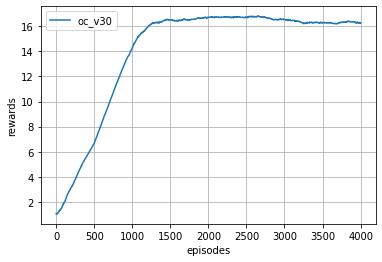

In [32]:

nepisodes = 4000
level = [0,1,3,4]
plt.xlabel('episodes')
plt.ylabel('rewards')
#plt.plot(range(nepisodes), smooth(nrewards[3][0:4000],500),label ='oc_v3')
plt.plot(range(nepisodes), smooth(temp_rewards[0:4000],500),label ='oc_v30')
#for i in [0,1,3]:
    #plt.plot(range(nepisodes), smooth(trans_rewards[i],500),label ='oc_v'+str(level[i])+'_3')

plt.legend()
plt.grid(True)
plt.show()

In [123]:
from IPython.display import Latex

In [168]:
%%latex 
$$A \in \mathbb{R}^{|\mathcal{V}|\times|\mathcal{V}|}$$

<IPython.core.display.Latex object>

Displaying termination probabilities.

In [22]:
for run in range(5):
    
    termination_maps = np.array()
    
    for option in range(noptions):
        state = 0
        for i in range(13):
            for j in range(13):
                if termination_maps[option][i,j] == 0:
                    termination_maps[option][i,j] = option_terminations_list[run][option].pmf(state)
                    state += 1

    clear_output(True)
    print('Run: {}'.format(run))
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('option: 0', fontsize=20)
    plt.imshow(termination_maps[0], cmap='Blues')
    plt.axis('off')
    plt.subplot(142)
    plt.title('option: 1', fontsize=20)
    plt.imshow(termination_maps[1], cmap='Blues')
    plt.axis('off')
    plt.subplot(143)
    plt.title('option: 2', fontsize=20)
    plt.imshow(termination_maps[2], cmap='Blues')
    plt.axis('off')
    plt.subplot(144)
    plt.title('option: 3', fontsize=20)
    plt.imshow(termination_maps[3], cmap='Blues')
    plt.axis('off')
    plt.show()
    sleep(2)

AttributeError: 'Taxi003Env' object has no attribute 'occupancy'

### 4 Test the Agent

The goal is the east doorway.

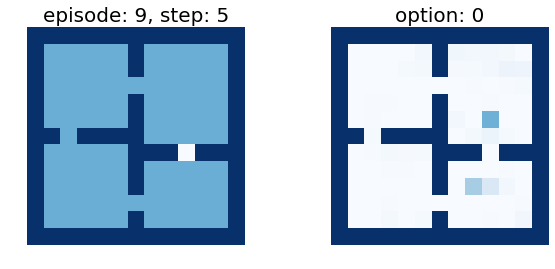

Goal reached!


In [11]:
# Turn off exploration while testing
policy_over_options.epsilon = 0
for option in range(noptions):
    option_policies[option].temperature = 1e-10

env = FourRooms()

nepisodes = 10

rng = np.random.RandomState(1234)

for episode in range(nepisodes):

    state = env.reset()

    option = policy_over_options.sample(state)

    for step in range(nsteps):
        
        action = option_policies[option].sample(state)
        
        state, reward, done, _ = env.step(action)

        # Termination might occur upon entering new state
        if option_terminations[option].sample(state):
            option = policy_over_options.sample(state)
        
        clear_output(True)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('episode: {}, step: {}'.format(episode, step), fontsize=20)
        plt.imshow(env.render(), cmap='Blues', )
        plt.axis('off')
        plt.subplot(122)
        plt.title('option: %s' %option, fontsize=20)
        plt.imshow(termination_maps[option], cmap='Blues')
        plt.axis('off')
        plt.show()

        if done:
            break
    
    print("Goal reached!")
    sleep(2)

In [8]:
%matplotlib nbagg
from matplotlib.pyplot import MultipleLocator
plt.plot([0,0.01,0.08,0.12,0.2,0.5,1.0], [0.53,0.56,0.65,0.67,0.69,0.73,0.75],'s-',  markerfacecolor='white', label = "TextGCN")
plt.ylim(0.5,0.8)
ax=plt.gca()
y_major_locator=MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Training percentage", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20, color = 'dodgerblue')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [7]:
import ipympl